## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from prondict import prondict
from lab2_proto import *
from lab2_tools import *
import warnings

## Preparations

In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

data = np.load('lab2_data.npz', allow_pickle=True)['data']
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
all_spkr_phone_HMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
one_spkr_phone_HMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()

# Print keys for each .npz file
print("Keys in 'lab2_data.npz':", list(data[1].keys()))
print("Keys in 'lab2_example.npz':", list(example.keys()))
print("Keys in 'lab2_models_all.npz':", list(all_spkr_phone_HMMs.keys()))
print("Keys in 'lab2_models_onespkr.npz':", list(one_spkr_phone_HMMs.keys()))


Keys in 'lab2_data.npz': ['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc']
Keys in 'lab2_example.npz': ['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc', 'obsloglik', 'logalpha', 'loglik', 'vloglik', 'vpath', 'logbeta', 'loggamma']
Keys in 'lab2_models_all.npz': ['f', 'k', 'n', 'r', 's', 't', 'v', 'w', 'z', 'ah', 'ao', 'ay', 'eh', 'ey', 'ih', 'iy', 'ow', 'sp', 'th', 'uw', 'sil']
Keys in 'lab2_models_onespkr.npz': ['f', 'k', 'n', 'r', 's', 't', 'v', 'w', 'z', 'ah', 'ao', 'ay', 'eh', 'ey', 'ih', 'iy', 'ow', 'sp', 'th', 'uw', 'sil']


## Concatenating HMMs

In [3]:
isolated = {}
for digit in prondict.keys():
  isolated[digit] = ["sil"] + prondict[digit] + ["sil"]

print(isolated)

all_spkr_word_HMMs, one_spkr_word_HMMs = {}, {}
for uterance in isolated:
    one_spkr_word_HMMs[uterance] = concatHMMs(one_spkr_phone_HMMs, isolated[uterance])
    all_spkr_word_HMMs[uterance] = concatHMMs(all_spkr_phone_HMMs, isolated[uterance]) 


{'o': ['sil', 'ow', 'sil'], 'z': ['sil', 'z', 'iy', 'r', 'ow', 'sil'], '1': ['sil', 'w', 'ah', 'n', 'sil'], '2': ['sil', 't', 'uw', 'sil'], '3': ['sil', 'th', 'r', 'iy', 'sil'], '4': ['sil', 'f', 'ao', 'r', 'sil'], '5': ['sil', 'f', 'ay', 'v', 'sil'], '6': ['sil', 's', 'ih', 'k', 's', 'sil'], '7': ['sil', 's', 'eh', 'v', 'ah', 'n', 'sil'], '8': ['sil', 'ey', 't', 'sil'], '9': ['sil', 'n', 'ay', 'n', 'sil']}


## 5.1 Gaussian

In [4]:
# Gaussian Plot
all_obsloglik = log_multivariate_normal_density_diag(example["lmfcc"], all_spkr_word_HMMs["o"]["means"], all_spkr_word_HMMs["o"]["covars"])
one_obsloglik = log_multivariate_normal_density_diag(example["lmfcc"], one_spkr_word_HMMs["o"]["means"], one_spkr_word_HMMs["o"]["covars"])

print(np.allclose(one_obsloglik, example["obsloglik"]))

True


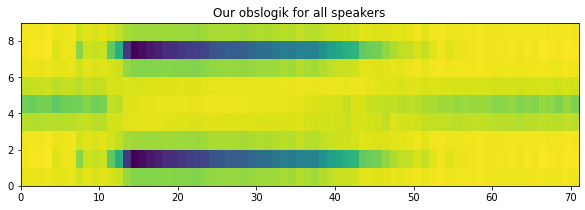

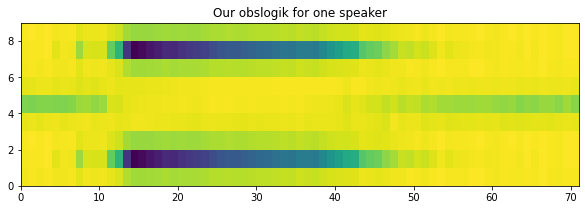

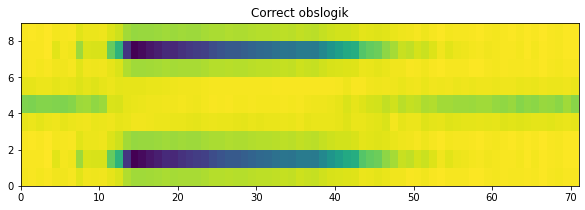

In [5]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(all_obsloglik.T, cmap='viridis')
ax.set_title('Our obslogik for all speakers')
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(one_obsloglik.T, cmap='viridis')
ax.set_title('Our obslogik for one speaker')
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(example["obsloglik"].T, cmap='viridis')
ax.set_title('Correct obslogik')
plt.show()

## 5.2 Forward

In [6]:
# Forward
logalpha = forward(example["obsloglik"], np.log(one_spkr_word_HMMs["o"]["startprob"]), np.log(one_spkr_word_HMMs["o"]["transmat"]))
print(np.allclose(logalpha, example["logalpha"]))

forward_loglik = logsumexp(logalpha[-1])
print(np.allclose(forward_loglik, example["loglik"]))


True
True


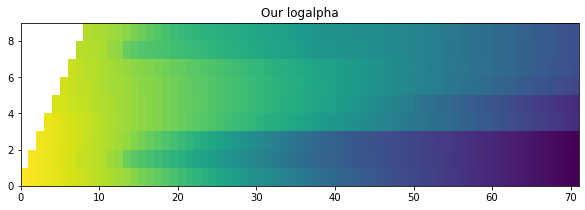

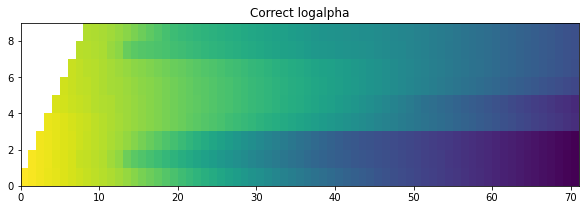

In [7]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(logalpha.T, cmap='viridis')
ax.set_title('Our logalpha')
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(example["logalpha"].T, cmap='viridis')
ax.set_title('Correct logalpha')
plt.show()

In [8]:
one_acc = score_forward(one_spkr_word_HMMs, data)
all_acc = score_forward(all_spkr_word_HMMs, data)
print(one_acc)
print(all_acc)


Correct guesses: 34
Correct guesses: 43
77.27272727272727
97.72727272727273


## 5.3 Viterbi

In [9]:
# Compute Viterbi path and likelihood
viterbi_loglik, viterbi_path = viterbi(one_obsloglik, np.log(one_spkr_word_HMMs['o']['startprob'][:-1]), np.log(one_spkr_word_HMMs['o']['transmat'][:-1, :-1]), forceFinalState=True)

print(np.allclose(viterbi_loglik, example["vloglik"]))


True


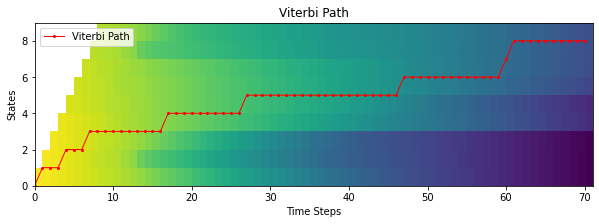

In [10]:
# Plotting the best path on the alpha array
fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(logalpha.T, cmap='viridis')
ax.plot(viterbi_path, color='r', marker='o', markersize=2, linestyle='-', linewidth=1, label='Viterbi Path')
ax.set_title("Viterbi Path")
ax.set_xlabel('Time Steps')
ax.set_ylabel('States')
ax.legend()
plt.show()


In [11]:
one_acc = score_viterbi(one_spkr_word_HMMs, data)
all_acc = score_viterbi(all_spkr_word_HMMs, data)
print(one_acc)
print(all_acc)

Correct guesses: 34
Correct guesses: 44
77.27272727272727
100.0


## 5.4 Backward

In [12]:
logbeta = backward(one_obsloglik, np.log(one_spkr_word_HMMs['o']['startprob']), np.log(one_spkr_word_HMMs['o']['transmat']))

print(np.allclose(logbeta, example["logbeta"]))

True


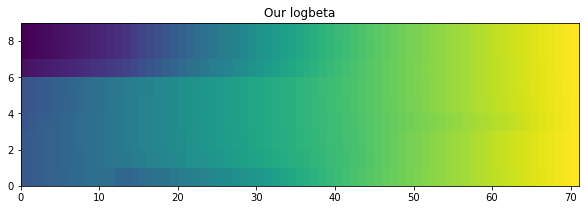

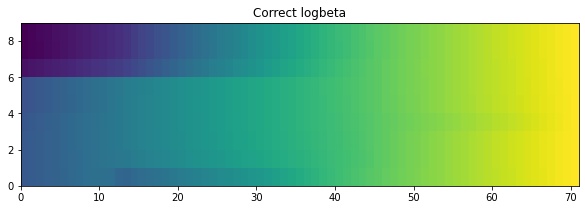

In [13]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(logbeta.T, cmap='viridis')
ax.set_title('Our logbeta')
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(example["logbeta"].T, cmap='viridis')
ax.set_title('Correct logbeta')
plt.show()

## 6.1 State Posterior Probabilities

In [14]:
# one_obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], one_spkr_word_HMMs['o']['means'], one_spkr_word_HMMs['o']['covars'])
# logalpha_onespkr = forward(one_obsloglik, np.log(one_spkr_word_HMMs['o']['startprob']), np.log(one_spkr_word_HMMs['o']['transmat']))
# logbeta_onespkr = backward(one_obsloglik, np.log(one_spkr_word_HMMs['o']['startprob']), np.log(one_spkr_word_HMMs['o']['transmat']))

loggamma = statePosteriors(logalpha, logbeta)

print(f"Each time step sum:\n{np.sum(np.exp(loggamma), axis=1)}")

Each time step sum:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


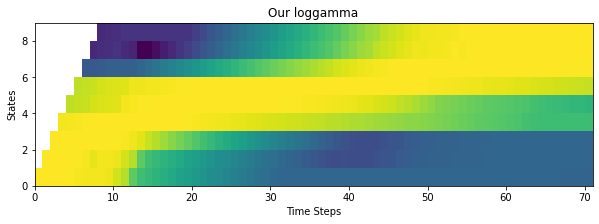

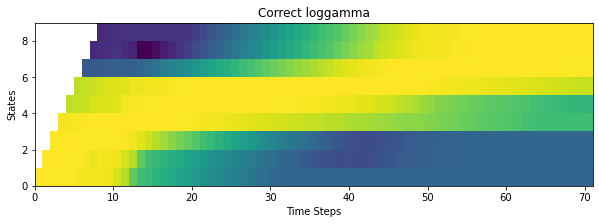

In [15]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(loggamma.T, cmap='viridis')
ax.set_title("Our loggamma")
ax.set_xlabel('Time Steps')
ax.set_ylabel('States')
plt.show()


fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(example["loggamma"].T, cmap='viridis')
ax.set_title("Correct loggamma")
ax.set_xlabel('Time Steps')
ax.set_ylabel('States')
plt.show()


In [22]:
# Load data and models
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
model = phoneHMMs['ow']  

# Extract necessary model parameters
means = model['means']
covars = model['covars']

# Time steps and number of states
n_steps, n_states = example['obsloglik'].shape

# Compute the log probabilities for each state using diagonal covariance matrices
state_likelihoods = log_multivariate_normal_density_diag(example['lmfcc'], means, covars)

# Convert log likelihoods to probabilities
state_probabilities = np.exp(state_likelihoods - np.max(state_likelihoods, axis=1, keepdims=True))
gamma_gmm = state_probabilities / np.sum(state_probabilities, axis=1, keepdims=True)

# Display or use the gamma_gmm for further analysis
print("GMM-based state posteriors computed successfully.")

GMM-based state posteriors computed successfully.


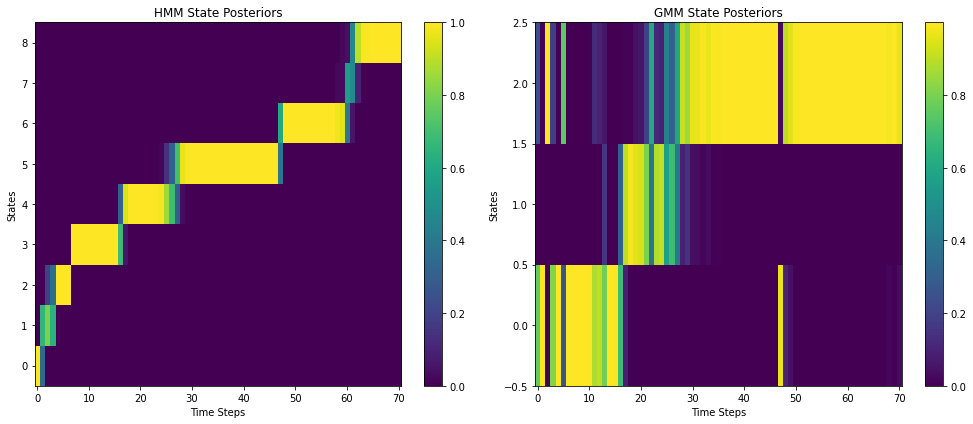

In [23]:
# Load HMM posteriors
loggamma_hmm = example['loggamma']
gamma_hmm = np.exp(loggamma_hmm - np.max(loggamma_hmm, axis=1, keepdims=True))
gamma_hmm /= np.sum(gamma_hmm, axis=1, keepdims=True)

# Comparison could be visual if using plots
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title('HMM State Posteriors')
plt.imshow(gamma_hmm.T, aspect='auto', origin='lower')
plt.xlabel('Time Steps')
plt.ylabel('States')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('GMM State Posteriors')
plt.imshow(gamma_gmm.T, aspect='auto', origin='lower')
plt.xlabel('Time Steps')
plt.ylabel('States')
plt.colorbar()

plt.tight_layout()
plt.show()

## 6.2 Retraining the Emission Probability Distributions

In [ ]:
# Baum-welch
log_gamma = example["loggamma"]#statePosteriors(logalpha, logbeta)



example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
observed_data = example['lmfcc']

means, covars = baum_welch(observed_data, np.log(one_spkr_word_HMMs['o']['startprob']),
    np.log(one_spkr_word_HMMs['o']['transmat']), means, covars, n_iter=10, varianceFloor=5.0)

# Viterbi

log_emlik = log_multivariate_normal_density_diag(observed_data, means, covars)

# Compute Viterbi path and likelihood
viterbi_loglik, viterbi_path = viterbi(log_emlik, np.log(one_spkr_word_HMMs['o']['startprob'][:-1]), 
    np.log(one_spkr_word_HMMs['o']['transmat'][:-1, :-1]), forceFinalState=True)

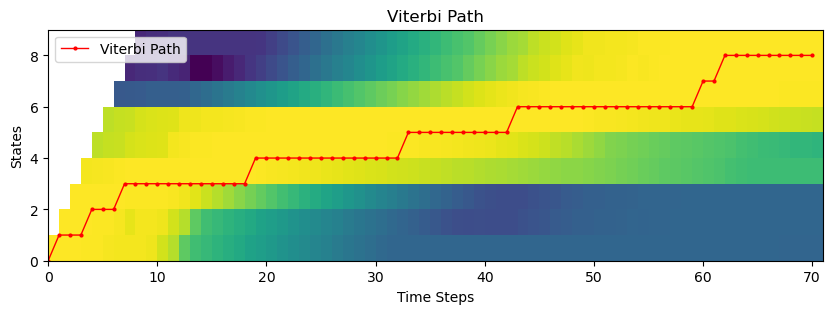

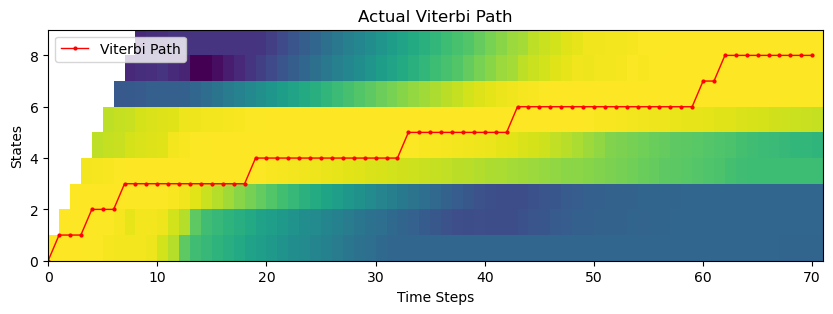

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(log_gamma.T, cmap='viridis')
ax.plot(viterbi_path, color='r', marker='o', markersize=2, linestyle='-', linewidth=1, label='Viterbi Path')
ax.set_title("Viterbi Path")
ax.set_xlabel('Time Steps')
ax.set_ylabel('States')
ax.legend()
plt.show()


fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(example["loggamma"].T, cmap='viridis')
ax.plot(viterbi_path, color='r', marker='o', markersize=2, linestyle='-', linewidth=1, label='Viterbi Path')
ax.set_title("Actual Viterbi Path")
ax.set_xlabel('Time Steps')
ax.set_ylabel('States')
ax.legend()
plt.show()